# Discount Impact
- Compare `Discount` Sales and `Non-Discount` Sales
- `Net Impact of Discounts` = `Discount Total Sales` − `Non-Discount Total Sales`
- Net Impact of Discounts Trend over `Years`

### Loading data

In [1]:
# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sqlalchemy import create_engine

# Define the connection details
server = 'DESKTOP-D57LVN9\SQLEXPRESS'
database = 'ContosoRetail'
username = 'sa'
password = '281202'

# Create the connection string
connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'

# Create the engine
engine = create_engine(connection_string)

# Write SQL query
query = "select * from ContosoRetail_df"

# Load data into a pandas DataFrame
df_origin = pd.read_sql(query, engine, index_col='SalesKey')

# No need to explicitly close the engine, but it’s good practice to dispose of it when done
engine.dispose()

### Calculating Discounts Sales and Non-Discounts Sales

In [2]:
# Discount and Non-Discount
df_discounts = df_origin[df_origin['DiscountAmount'] > 0][['ProductName','SalesAmount']]
df_non_discounts = df_origin[df_origin['DiscountAmount'] == 0][['ProductName','SalesAmount']]

# Calculating total sales for Discount and Non-Discount
df_discounts = df_discounts.groupby('ProductName')['SalesAmount'].sum().to_frame(name='Sales_Discounts')
df_non_discounts = df_non_discounts.groupby('ProductName')['SalesAmount'].sum().to_frame(name='Sales_Non_Discounts')

In [3]:
df_discounts

,Sales_Discounts
ProductName,
A. Datum Advanced Digital Camera M300 Azure,1.661709e+06
A. Datum Advanced Digital Camera M300 Black,2.279877e+06
A. Datum Advanced Digital Camera M300 Green,2.189746e+06
A. Datum Advanced Digital Camera M300 Grey,2.156216e+06
A. Datum Advanced Digital Camera M300 Orange,2.313728e+06
...,...
WWI Wireless Transmitter and Bluetooth Headphones X250 Black,8.485961e+05
WWI Wireless Transmitter and Bluetooth Headphones X250 Blue,1.002597e+06
WWI Wireless Transmitter and Bluetooth Headphones X250 Red,9.142809e+05


In [4]:
df_non_discounts

,Sales_Non_Discounts
ProductName,
A. Datum Advanced Digital Camera M300 Azure,1861437.50
A. Datum Advanced Digital Camera M300 Black,1823360.50
A. Datum Advanced Digital Camera M300 Green,1950975.00
A. Datum Advanced Digital Camera M300 Grey,1662758.50
A. Datum Advanced Digital Camera M300 Orange,1907054.50
...,...
WWI Wireless Transmitter and Bluetooth Headphones X250 Black,761469.54
WWI Wireless Transmitter and Bluetooth Headphones X250 Blue,674223.03
WWI Wireless Transmitter and Bluetooth Headphones X250 Red,731470.74


### Merging 2 DataFrames for comparison

In [5]:
# Merging 2 DataFrames
df_discounts_merge = df_discounts.merge(df_non_discounts, on='ProductName').reset_index().sort_values(by=(['Sales_Discounts','Sales_Non_Discounts']), ascending=False).tail(10)
df_discounts_merge

,ProductName,Sales_Discounts,Sales_Non_Discounts
551,Contoso Digital Camera Accessory kit M200 Blue,38850.6450,38359.50
897,Contoso Smart Battery M901 Blue,33831.0450,20884.00
2184,SV USB Sync Charge Cable E700 Black,15594.4161,11400.71
2185,SV USB Sync Charge Cable E700 Blue,15269.9068,11683.29
2187,SV USB Sync Charge Cable E700 White,14854.2157,11086.29
2186,SV USB Sync Charge Cable E700 Silver,13993.7198,11012.66
2183,SV USB Data Cable E600 Silver,9993.1925,6497.05
2180,SV USB Data Cable E600 Black,9078.5895,6546.45
2181,SV USB Data Cable E600 Grey,8959.9345,7129.75
2182,SV USB Data Cable E600 Pink,8278.0245,6704.15


### Plotting to see which Total Sales is higher

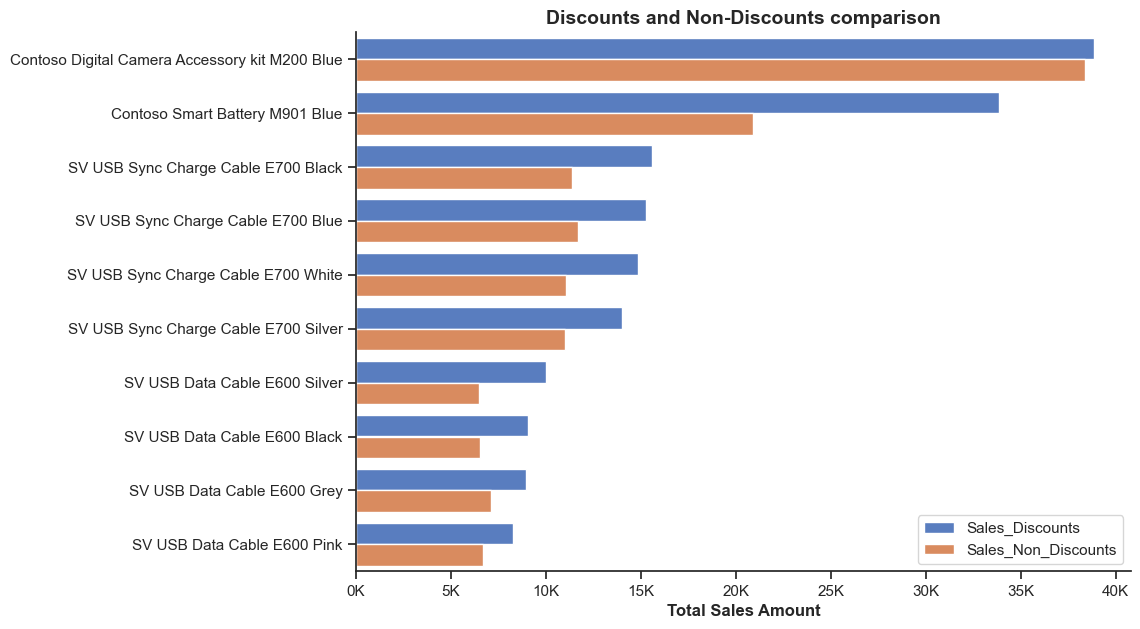

In [6]:
# Melting DataFrame
df_discounts_merge_melt = df_discounts_merge.melt(id_vars='ProductName', var_name='Metrics', value_name='Amount')

# Plotting
plt.figure(figsize=(10,7))
sns.set_theme(style='ticks')
barplot = sns.barplot(
    data=df_discounts_merge_melt,
    x='Amount',
    y='ProductName',
    hue='Metrics',
    palette='muted'
)
sns.despine()

# Formatting plot
plt.title('Discounts and Non-Discounts comparison', fontweight='bold', fontsize=14)
plt.xlabel('Total Sales Amount', fontweight='bold')
plt.ylabel('')
plt.legend(loc='lower right')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

### Net Impact of Discounts

In [7]:
# Calculating Net Impact of Discounts
df_date_discount = df_origin[df_origin['DiscountAmount'] > 0][['DateKey','SalesAmount']]
df_date_non_discount = df_origin[df_origin['DiscountAmount'] == 0][['DateKey','SalesAmount']]

df_date_discount = df_date_discount.groupby('DateKey')['SalesAmount'].sum().to_frame(name='Sales_Discount')
df_date_non_discount = df_date_non_discount.groupby('DateKey')['SalesAmount'].sum().to_frame(name='Sales_Non_Discount')

# Merging 2 DataFrames
df_date_merge = df_date_discount.merge(df_date_non_discount, on='DateKey')
df_date_merge = df_date_merge.reset_index()

In [8]:
# Create month and year columns
df_date_merge['Year'] = df_date_merge['DateKey'].dt.year
df_date_merge['Month'] = df_date_merge['DateKey'].dt.month

df_date_merge

,DateKey,Sales_Discount,Sales_Non_Discount,Year,Month
0,2022-01-01,7.030574e+06,1279923.73,2022,1
1,2022-01-02,6.941887e+06,1384255.57,2022,1
2,2022-01-03,7.136469e+06,1273449.66,2022,1
3,2022-01-04,7.046153e+06,1185726.27,2022,1
4,2022-01-05,6.867744e+06,1221932.01,2022,1
...,...,...,...,...,...
1091,2024-12-27,8.824258e+06,1756561.82,2024,12
1092,2024-12-28,8.605358e+06,1645878.72,2024,12
1093,2024-12-29,8.815501e+06,1848441.34,2024,12
1094,2024-12-30,8.890866e+06,1613614.97,2024,12


In [9]:
# Pivot sales DISCOUNT
df_sales_discount = df_date_merge.pivot_table(index='Month', columns='Year', aggfunc='mean', values='Sales_Discount')
df_sales_non_discount = df_date_merge.pivot_table(index='Month', columns='Year', aggfunc='mean', values='Sales_Non_Discount')

# Convert month num to month name
df_sales_discount = df_sales_discount.reset_index()
df_sales_discount['Month'] = df_sales_discount['Month'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_sales_discount = df_sales_discount.set_index('Month')

df_sales_non_discount = df_sales_non_discount.reset_index()
df_sales_non_discount['Month'] = df_sales_non_discount['Month'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_sales_non_discount = df_sales_non_discount.set_index('Month')

In [10]:
df_sales_discount

Year,2022,2023,2024
Month,,,
Jan,7.341415e+06,7.557263e+06,7.277239e+06
Feb,9.074669e+06,8.365234e+06,7.992608e+06
Mar,8.111095e+06,7.829132e+06,7.314437e+06
Apr,1.302172e+06,2.234448e+06,2.028037e+06
May,1.852144e+06,2.337577e+06,2.416373e+06
Jun,1.825066e+06,2.293181e+06,2.434647e+06
Jul,6.284220e+06,6.090814e+06,4.716462e+06
Aug,8.800631e+06,7.729927e+06,6.315436e+06
Sep,8.931013e+06,7.796255e+06,6.231400e+06


In [11]:
df_sales_non_discount

Year,2022,2023,2024
Month,,,
Jan,1.362948e+06,1.457602e+06,1.425030e+06
Feb,1.575902e+06,1.598191e+06,1.520475e+06
Mar,1.582031e+06,1.527660e+06,1.420078e+06
Apr,1.203651e+07,9.636857e+06,8.277222e+06
May,1.180686e+07,8.988131e+06,8.601700e+06
Jun,1.183485e+07,8.977913e+06,8.608686e+06
Jul,6.284082e+06,6.361579e+06,6.037552e+06
Aug,3.729364e+06,3.880981e+06,4.169413e+06
Sep,3.707141e+06,3.984478e+06,4.227944e+06


<Axes: xlabel='Month'>

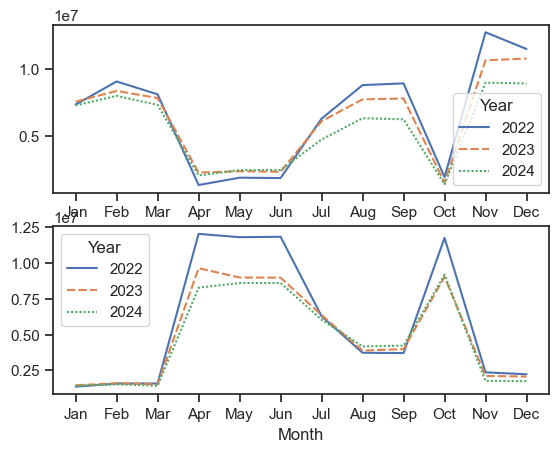

In [12]:
# Subplots
fig, ax = plt.subplots(2,1)

# Plotting
sns.set_theme(style='ticks')

sns.lineplot(
    data=df_sales_discount,
    ax=ax[0]
)

sns.lineplot(
    data=df_sales_non_discount,
    ax=ax[1]
)